# Задание 2: прогнозирование синтетического временного ряда

In [1]:
# Импортируем необходимые библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.model_selection import train_test_split
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
RANDOM_STATE = 42
TEST_SIZE = 0.20

## Генерация данных

Сгенерируем синтетический временной ряд, содержащий 1000 наблюдений.

In [2]:
# Параметры ряда
n_observations = 1000
t = np.arange(n_observations)

# Тренд
trend = 0.02 * t 

# Сезонность
seasonality = 2 * np.sin(2 * np.pi * t / 50) 

# Случайный шум
np.random.seed(RANDOM_STATE)
noise = np.random.normal(0, 0.5, size=n_observations)

# Итоговый временной ряд
time_series = trend + seasonality + noise

In [3]:
# Создаём датафрейм с данными
dates = pd.date_range(start='2025-01-01', periods=n_observations, freq='D')
df = pd.DataFrame({'value': time_series}, index=dates)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1000 entries, 2025-01-01 to 2027-09-27
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   1000 non-null   float64
dtypes: float64(1)
memory usage: 15.6 KB


## Разделение данных

Разделим датасет на тренировочную и тестовую выборки в соотношении 80:20.

In [4]:
train, test = train_test_split(df, shuffle=False, test_size=TEST_SIZE)

In [5]:
# Проверим разбиение
train.shape, test.shape

((800, 1), (200, 1))

## Визуализация данных

Построим график временного ряда.

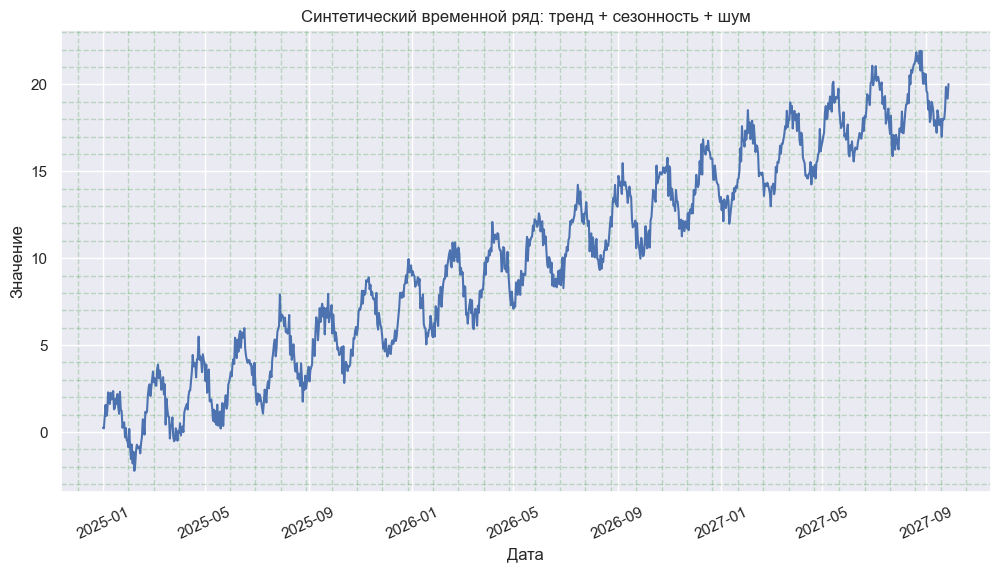

In [6]:
# Визуализация временного ряда
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x=df.index, y='value')
plt.grid(True, linestyle='--', color='green', alpha=0.2, which='minor')
plt.minorticks_on()
plt.tick_params(which='minor')
plt.xticks(rotation = 25)
plt.title('Синтетический временной ряд: тренд + сезонность + шум')
plt.xlabel('Дата')
plt.ylabel('Значение');

График демонстрирует искусственный временной ряд, состоящий из трёх компонентов:

Линейного восходящего тренда — общее постепенное увеличение уровня ряда со временем,

Периодической сезонности — чёткие колебания с фиксированным периодом (в данном случае 50 дней),

Случайного гауссовского шума — добавленная вариативность, имитирующая реальные рыночные или природные флуктуации.

## Построение моделей

Построим модели для прогнозирования временного ряда с использованием алгоритмов автокорреляционной модели и модели экспоненциального сглаживания.

In [7]:
# AR модель 
ar = AutoReg(train['value'], lags=30).fit()
ar_pred = ar.forecast(steps=len(test))

# ETS модель
ets = ExponentialSmoothing(
    train['value'], 
    trend='add', 
    seasonal='add', 
    seasonal_periods=50
).fit()
ets_pred = ets.forecast(steps=len(test))

## Оценка качества моделей

Оценим качество моделей на тестовой выборке, используем MAE и RMSE.

In [8]:
# Оценка качества
print(f'Для AR модели метрика MAE = {mean_absolute_error(test['value'], ar_pred):.4f}, RMSE = {np.sqrt(mean_squared_error(test['value'], ar_pred)):.4f}')
print(f'Для ETS модели метрика MAE = {mean_absolute_error(test['value'], ets_pred):.4f}, RMSE = {np.sqrt(mean_squared_error(test['value'], ets_pred)):.4f}')

Для AR модели метрика MAE = 0.5171, RMSE = 0.6555
Для ETS модели метрика MAE = 0.3940, RMSE = 0.4964


Модель ETS значительно точнее - ошибки ниже на 24% по MAE и 24% по RMSE.

Это ожидаемо: ETS учитывает тренд и сезонность, заложенные в данных, тогда как AR моделирует только автокорреляцию.

ETS лучше подходит для данного ряда, так как он явно содержит линейный тренд и периодические колебания.

## Визуализация прогнозов

Построим графики, сравнивающие истинные значения временного ряда и прогнозы каждой модели на тестовой выборке.

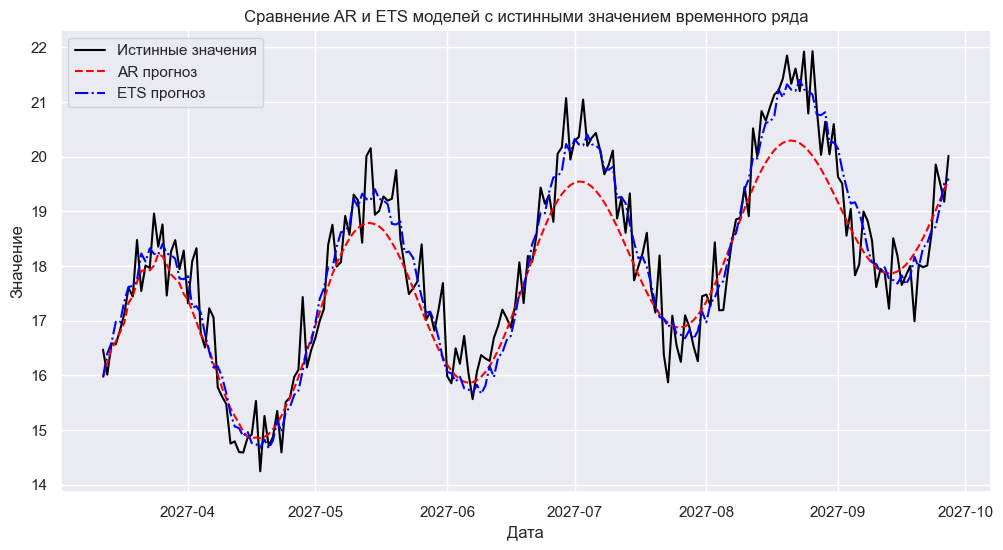

In [9]:
# Сравниваем обе модели на одном графике
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['value'], label='Истинные значения', color='black')
plt.plot(test.index, ar_pred, label='AR прогноз', color='red', linestyle='--')
plt.plot(test.index, ets_pred, label='ETS прогноз', color='blue', linestyle='-.')
plt.title('Сравнение AR и ETS моделей с истинными значением временного ряда')
plt.legend()
plt.xlabel('Дата')
plt.ylabel('Значение');

Модель ETS точно следует за динамикой ряда, корректно улавливая как тренд, так и сезонные колебания. Это объясняет её низкие ошибки (MAE = 0.394, RMSE = 0.496).

Модель AR отстаёт от поворотных точек, особенно в пиках и спадах, и менее чувствительна к тренду. Её прогнозы более сглажены, что приводит к большим отклонениям.

## **Итоговые выводы**

Таким образом мы создали синтетический временной ряд и обучили на нем модели:

1. Построили модель для прогнозирования временного ряда.

Для этого были выполнены следующие действия:

- Сгенерирован датасет, содержащий 1000 наблюдений, разделили его на обучающую и тестовую выборку в соотношении 80:20
  
- Визуализировали данные, построили график временного ряда
    
- Построили модели для прогнозирования временного ряда с использованием следующих алгоритмов:

  Автокорреляционная модель (AR)

  Модель экспоненциального сглаживания (ETS)

- Оценили качество моделей на тесте с помощью метрик MAE и RMSE:

  Для AR модели метрика **MAE** = 0.5171, **RMSE** = 0.6555
  
  Для ETS модели метрика **MAE** = 0.3940, **RMSE** = 0.4964

- Построили графики, сравнивающие истинные значения временного ряда и прогнозы каждой модели на тестовой выборке:

      для временных рядов с выраженным трендом и сезонностью модель ETS предпочтительнее, поскольку явно моделирует эти компоненты, в то время как AR ограничивается линейной зависимостью от прошлых значений.